#Nepal Monument Identification Model Training Updated and Optimized Version

In [1]:
from google.colab import drive
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import time
from datetime import datetime

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


**Configuration**

In [3]:
DATASET_PATH = '/content/drive/MyDrive/NeuralNetwork/nepal_dataset_balanced'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 25
LEARNING_RATE = 0.001

**Output Paths**

In [4]:
MODEL_SAVE_PATH = '/content/drive/MyDrive/NeuralNetwork/models'
RESULTS_PATH = '/content/drive/MyDrive/NeuralNetwork/results'

**Create directories if they don't exist**

In [5]:
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)
os.makedirs(RESULTS_PATH, exist_ok=True)

In [6]:
print("NEPAL MONUMENT IDENTIFICATION - MODEL TRAINING")

print(f"\nDataset: {DATASET_PATH}")
print(f"Image Size: {IMG_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")
print(f"Learning Rate: {LEARNING_RATE}")

NEPAL MONUMENT IDENTIFICATION - MODEL TRAINING

Dataset: /content/drive/MyDrive/NeuralNetwork/nepal_dataset_balanced
Image Size: (224, 224)
Batch Size: 32
Epochs: 25
Learning Rate: 0.001


##Data Generation

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,                    # Normalize pixel values to [0,1]
    validation_split=0.2              # 20% for validation
)

In [8]:
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

**Load training and validation data**

In [9]:
print("\nLoading training data...")
train_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)


Loading training data...
Found 1138 images belonging to 6 classes.


In [10]:
print("Loading validation data...")
validation_generator = validation_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Loading validation data...
Found 283 images belonging to 6 classes.


**Class information**

In [11]:
num_classes = len(train_generator.class_indices)
class_names = list(train_generator.class_indices.keys())

In [12]:
print("DATASET INFORMATION")

print(f"Number of monument classes: {num_classes}")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Steps per epoch (train): {len(train_generator)}")
print(f"Steps per epoch (val): {len(validation_generator)}")
print(f"\nMonument IDs: {class_names}")

DATASET INFORMATION
Number of monument classes: 6
Training samples: 1138
Validation samples: 283
Steps per epoch (train): 36
Steps per epoch (val): 9

Monument IDs: ['122791', '152527', '168267', '4137', '79922', '98003']


In [13]:
# Saving class mapping
class_mapping = {
    'class_indices': train_generator.class_indices,
    'num_classes': num_classes,
    'class_names': class_names
}
with open(os.path.join(RESULTS_PATH, 'class_mapping.json'), 'w') as f:
    json.dump(class_mapping, f, indent=2)
print(f"\nClass mapping saved to: {RESULTS_PATH}/class_mapping.json")


Class mapping saved to: /content/drive/MyDrive/NeuralNetwork/results/class_mapping.json


##Model Creation

In [14]:
"""
    Creating a transfer learning model using MobileNetV2
"""

def create_model(num_classes):
    print("\nCreating MobileNetV2 model...")

    # Loading pre-trained MobileNetV2 (without top classification layer)
    base_model = MobileNetV2(
        input_shape=(*IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )

    # the base model is freezed initially
    base_model.trainable = False
    print(f"Loaded MobileNetV2 with ImageNet weights")
    print(f"Base model frozen will be trained later.")

    # custom classification head
    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ], name='Nepal_Monument_Classifier')

    return model, base_model

In [15]:
#model creation
model, base_model = create_model(num_classes)


Creating MobileNetV2 model...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Loaded MobileNetV2 with ImageNet weights
Base model frozen will be trained later.


In [16]:
print("MODEL ARCHITECTURE:\n")
model.summary()

MODEL ARCHITECTURE:



Model: "Nepal_Monument_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,593,606 (9.89 MB)

 Trainable params: 332,550 (1.27 MB)

 Non-trainable params: 2,261,056 (8.63 MB)

In [17]:
# parameters
total_params = model.count_params()
trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
non_trainable_params = total_params - trainable_params

print("PARAMETER SUMMARY:")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Non-trainable parameters: {non_trainable_params:,}")


PARAMETER SUMMARY:
Total parameters: 2,593,606
Trainable parameters: 332,550
Non-trainable parameters: 2,261,056


##Model Compilation

In [18]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_accuracy'),
        keras.metrics.TopKCategoricalAccuracy(k=5, name='top_5_accuracy')
    ]
)

In [19]:
print("Model compiled successfully")
print(f"  Optimizer: Adam (lr={LEARNING_RATE})")
print(f"  Loss: Categorical Crossentropy")
print(f"  Metrics: Accuracy")

Model compiled successfully
  Optimizer: Adam (lr=0.001)
  Loss: Categorical Crossentropy
  Metrics: Accuracy


##Setting up Callbacks

In [20]:
# Model checkpoint
checkpoint_path = os.path.join(MODEL_SAVE_PATH, 'best_model.keras')
checkpoint = keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1,
    mode='max'
)
print(f"Checkpoint: {checkpoint_path}")

# Early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1
)
print(f"Early stopping: patience=7")

# Reduceing learning rate
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)
print(f"Learning rate reduction: factor=0.5, patience=3")

# TensorBoard logging
log_dir = os.path.join(RESULTS_PATH, 'logs', datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1
)
print(f"TensorBoard logging: {log_dir}")

# CSV Logger
csv_logger = keras.callbacks.CSVLogger(
    os.path.join(RESULTS_PATH, 'training_log.csv')
)
print(f"CSV logging enabled")

Checkpoint: /content/drive/MyDrive/NeuralNetwork/models/best_model.keras
Early stopping: patience=7
Learning rate reduction: factor=0.5, patience=3
TensorBoard logging: /content/drive/MyDrive/NeuralNetwork/results/logs/20260129-130035
CSV logging enabled


##Training with forzen based **model**

In [21]:
print("Training only the custom classification head")
print("Base MobileNetV2 layers are frozen\n")

# start time
training_start = time.time()

# Training the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stopping, reduce_lr, tensorboard_callback, csv_logger],
    verbose=1
)

training_time = time.time() - training_start

print(f"Training time: {training_time/60:.2f} minutes")

# Evaluate on validation set
print("\nEvaluating on validation set...")
training_result = model.evaluate(validation_generator, verbose=1)


print("Traning Results:")
print(f"Validation Loss:        {training_result[0]:.4f}")
print(f"Validation Accuracy:    {training_result[1]:.4f} ({training_result[1]*100:.2f}%)")
print(f"Top-3 Accuracy:         {training_result[2]:.4f} ({training_result[2]*100:.2f}%)")
print(f"Top-5 Accuracy:         {training_result[3]:.4f} ({training_result[3]*100:.2f}%)")

Training only the custom classification head
Base MobileNetV2 layers are frozen



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.5118 - loss: 1.9695 - top_3_accuracy: 0.7888 - top_5_accuracy: 0.9364 
Epoch 1: val_accuracy improved from -inf to 0.79505, saving model to /content/drive/MyDrive/NeuralNetwork/models/best_model.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 656s 18s/step - accuracy: 0.5152 - loss: 1.9582 - top_3_accuracy: 0.7910 - top_5_accuracy: 0.9374 - val_accuracy: 0.7951 - val_loss: 1.0118 - val_top_3_accuracy: 0.9258 - val_top_5_accuracy: 0.9859 - learning_rate: 0.0010
Epoch 2/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8447 - loss: 0.8898 - top_3_accuracy: 0.9825 - top_5_accuracy: 0.9989
Epoch 2: val_accuracy improved from 0.79505 to 0.83746, saving model to /content/drive/MyDrive/NeuralNetwork/models/best_model.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 177s 5s/step - accuracy: 0.8447 - loss: 0.8893 - top_3_accuracy: 0.9825 - top_5_accuracy: 0.9989 - val_accuracy: 0.8375 - val_loss: 0.9562 - val_top_3_accuracy: 0.9435 - val_top_5_accuracy: 0.9

##Saving the model

In [22]:
print("SAVING FINAL MODEL")

final_model_path = os.path.join(MODEL_SAVE_PATH, 'nepal_monument_model.keras')
model.save(final_model_path)
print(f"Final model saved: {final_model_path}")

# Saving class names
class_names_path = os.path.join(MODEL_SAVE_PATH, 'class_names.json')
with open(class_names_path, 'w') as f:
    json.dump(class_names, f, indent=2)
print(f"Class names saved: {class_names_path}")

SAVING FINAL MODEL
Final model saved: /content/drive/MyDrive/NeuralNetwork/models/nepal_monument_model.keras
Class names saved: /content/drive/MyDrive/NeuralNetwork/models/class_names.json


##Training Visualization

In [23]:
def plot_training_history(history):
    """Plot training and validation metrics"""

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Nepal Monument Model Training History', fontsize=16, fontweight='bold')

    # training data
    training_epoches = range(1, len(history.history['accuracy']) + 1)


    # Plot 1: Accuracy
    axes[0, 0].plot(training_epoches, history.history['accuracy'],
                    'b-', label='Train Accuracy', linewidth=2)
    axes[0, 0].plot(training_epoches, history.history['val_accuracy'],
                    'r-', label='Val Accuracy', linewidth=2)

    axes[0, 0].set_xlabel('Epoch', fontweight='bold')
    axes[0, 0].set_ylabel('Accuracy', fontweight='bold')
    axes[0, 0].set_title('Model Accuracy', fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Plot 2: Loss
    axes[0, 1].plot(training_epoches, history.history['loss'],
                    'b-', label='Train Loss', linewidth=2)
    axes[0, 1].plot(training_epoches, history.history['val_loss'],
                    'r-', label='Val Loss', linewidth=2)


    axes[0, 1].set_xlabel('Epoch', fontweight='bold')
    axes[0, 1].set_ylabel('Loss', fontweight='bold')
    axes[0, 1].set_title('Model Loss', fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Plot 3: Top-3 Accuracy
    axes[1, 0].plot(training_epoches, history.history['top_3_accuracy'],
                    'b-', label='Train Top-3', linewidth=2)
    axes[1, 0].plot(training_epoches, history.history['val_top_3_accuracy'],
                    'r-', label='Val Top-3', linewidth=2)


    axes[1, 0].set_xlabel('Epoch', fontweight='bold')
    axes[1, 0].set_ylabel('Top-3 Accuracy', fontweight='bold')
    axes[1, 0].set_title('Top-3 Accuracy', fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Plot 4: Top-5 Accuracy
    axes[1, 1].plot(training_epoches, history.history['top_5_accuracy'],
                    'b-', label='Train Top-5', linewidth=2)
    axes[1, 1].plot(training_epoches, history.history['val_top_5_accuracy'],
                    'r-', label='Val Top-5', linewidth=2)


    axes[1, 1].set_xlabel('Epoch', fontweight='bold')
    axes[1, 1].set_ylabel('Top-5 Accuracy', fontweight='bold')
    axes[1, 1].set_title('Top-5 Accuracy', fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()

    # Saving plot
    plot_path = os.path.join(RESULTS_PATH, 'training_history.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"Training history plot saved: {plot_path}")
    plt.show()


Training history plot saved: /content/drive/MyDrive/NeuralNetwork/results/training_history.png


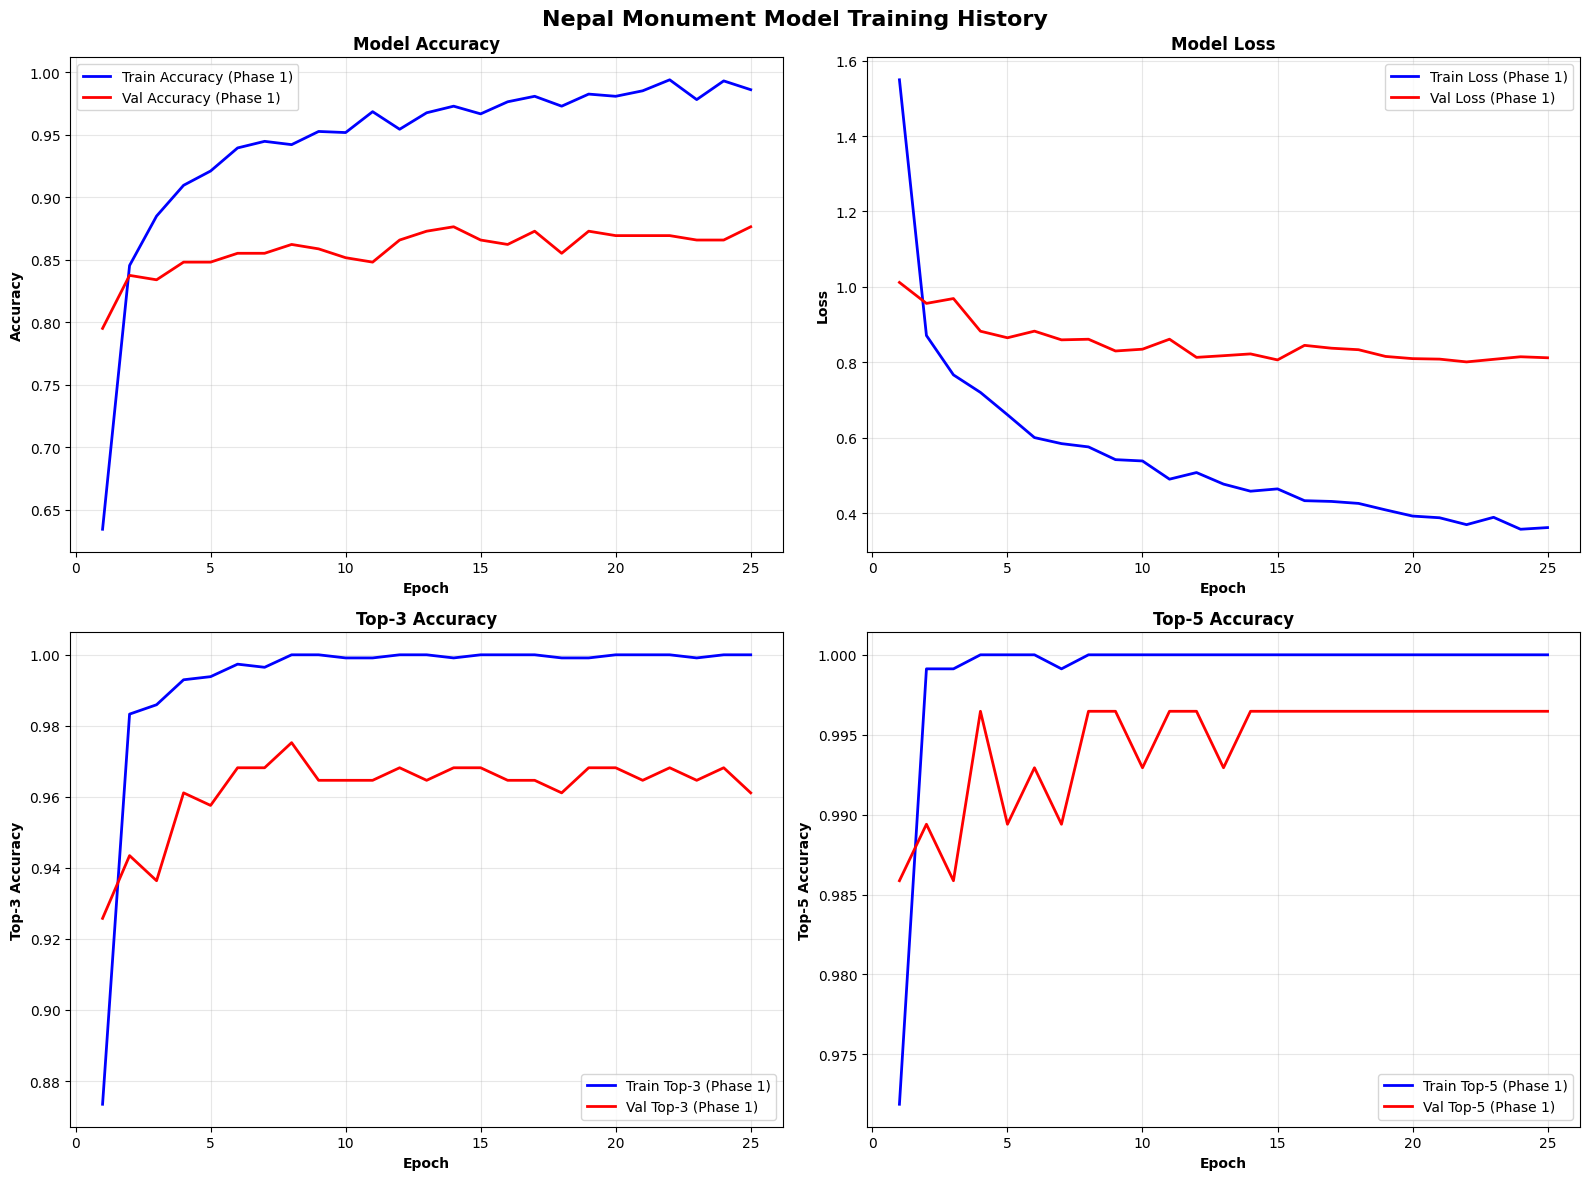

In [24]:
# Generate plots
plot_training_history(history)

##Training Summary

In [25]:
summary = {
    'dataset_path': DATASET_PATH,
    'num_classes': num_classes,
    'training_samples': train_generator.samples,
    'validation_samples': validation_generator.samples,
    'image_size': IMG_SIZE,
    'batch_size': BATCH_SIZE,
    'initial_learning_rate': LEARNING_RATE,
    'training': {
        'epochs_trained': len(history.history['accuracy']),
        'training_time_minutes': training_time / 60,
        'final_train_accuracy': float(history.history['accuracy'][-1]),
        'final_val_accuracy': float(history.history['val_accuracy'][-1]),
        'final_val_loss': float(history.history['val_loss'][-1]),
        'best_val_accuracy': float(max(history.history['val_accuracy']))
    }
}

print(summary)

{'dataset_path': '/content/drive/MyDrive/NeuralNetwork/nepal_dataset_balanced', 'num_classes': 6, 'training_samples': 1138, 'validation_samples': 283, 'image_size': (224, 224), 'batch_size': 32, 'initial_learning_rate': 0.001, 'training': {'epochs_trained': 25, 'training_time_minutes': 79.7349240342776, 'final_train_accuracy': 0.9859402179718018, 'final_val_accuracy': 0.8763250708580017, 'final_val_loss': 0.8119345903396606, 'best_val_accuracy': 0.8763250708580017}}


**Saving summary in a file. **

In [26]:
summary_path = os.path.join(RESULTS_PATH, 'training_summary.json')
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2)
print(f"Training summary saved: {summary_path}")

Training summary saved: /content/drive/MyDrive/NeuralNetwork/results/training_summary.json
